# Retrieve, process and store data

Scrape the employee list on the website of my former employer, store all pictures, and process them in a way to make them suitable as training data for an image generating GAN of employee faces. 

**Steps**

- Retrieve and store raw data
- Detect faces and crop to uniform size
- Store processed data

**Data Sources**

- `https://implementconsultinggroup.com/who-we-are/people/`: List of all employees at Implement Consulting Group

**Change-Log**

- 2020-09-23: Start project


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dev-&amp;-Test" data-toc-modified-id="Dev-&amp;-Test-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dev &amp; Test</a></span><ul class="toc-item"><li><span><a href="#Scrape-employee-fotos" data-toc-modified-id="Scrape-employee-fotos-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Scrape employee fotos</a></span></li><li><span><a href="#Detect-Faces" data-toc-modified-id="Detect-Faces-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Detect Faces</a></span></li><li><span><a href="#Crop-Pictures" data-toc-modified-id="Crop-Pictures-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Crop Pictures</a></span><ul class="toc-item"><li><span><a href="#Crop-and-resize-PIL-images" data-toc-modified-id="Crop-and-resize-PIL-images-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Crop and resize PIL images</a></span></li><li><span><a href="#Crop-and-resize-OpenCV-images" data-toc-modified-id="Crop-and-resize-OpenCV-images-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Crop and resize OpenCV images</a></span></li></ul></li></ul></li></ul></div>

---

In [2]:
import json
import os
from io import BytesIO

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from PIL import Image

## Dev & Test

### Scrape employee fotos

In [3]:
# Fetch web page content
url = "https://implementconsultinggroup.com/who-we-are/people/?altTemplate=GridJSON&id=0&sort=date&amount=1000&from=0"
response = requests.get(url)

In [4]:
# Response is in JSON-Format, save to dict
employees = json.loads(response.text)

# Parse dict - get foto source for first employee 
print(employees['modules'][0]['data']['media']['source'])

/media/1079/alr.jpg


In [5]:
len(employees['modules'])

795

(1766, 1179)


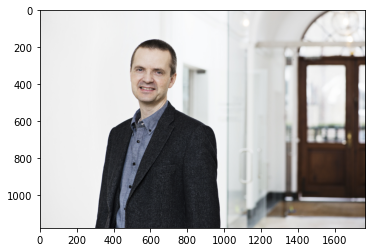

In [7]:
# Load image of first employee, display it and it's size
base_url = "https://implementconsultinggroup.com/"
path_to_pic = employees['modules'][0]['data']['media']['source']
url_to_image = base_url + path_to_pic

r = requests.get(url_to_image)
pil_img = Image.open(BytesIO(r.content))

print(pil_img.size)
plt.imshow(pil_img);

### Detect Faces

Use of a  pre-trained Haar feature-based cascade classifier for face detection from OpenCV. They are stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).

See here for [OpenCV Python Tutorials](https://docs.opencv.org/4.3.0/d6/d00/tutorial_py_root.html)

Notes: `haarcascade_frontalface_default.xml` was to sensitive, I played around with the detectMultiScale() params to get better results (see here for an [explanation and demo](https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Object_Detection_Face_Detection_Haar_Cascade_Classifiers.php)). But in the end I decided to use `haarcascade_frontalface_alt.xml`


Number of faces detected: 1


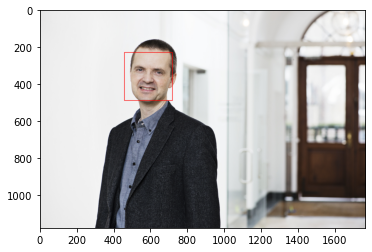

In [10]:
# Extract pre-trained face detector
face_cascade = cv2.CascadeClassifier("resources/haarcascade_frontalface_alt.xml")

# Convert PIL image to OpenCV image and this to gray scale
cv_img = np.array(pil_img)
cv_bgr = np.flip(cv_img, axis=-1)

# # ALT -  Load color (BGR) test_image
# cv_img = cv2.imread("resources/test_image.jpg")

cv_gray = cv2.cvtColor(cv_img, cv2.COLOR_BGR2GRAY)

# Find faces in image
faces = face_cascade.detectMultiScale(cv_gray)
print('Number of faces detected:', len(faces))

# Get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(cv_img,(x,y),(x+w,y+h),(255,0,0),2)
    
# Convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)

# Display the image, along with bounding box
plt.imshow(cv_img)
plt.show()

In [11]:
type(face_cascade)

cv2.CascadeClassifier

### Crop Pictures

Inspiration from [Stackoverflow](https://stackoverflow.com/questions/13211745/detect-face-then-autocrop-pictures)

cv2.imread returns on Numpy arrays? You can convert a Numpy array to a PIL image using Image.fromarray and you can convert a PIL image to a Numpy array with np.asarray(img). However, PIL use RGB order and cv2 uses BGR order, but that's easy enough to handle with Numpy operations. – PM 2Ring Dec 11 '17 at 5:44

The linked answer uses cv2.cvtColor(img, cv2.COLOR_BGR2RGB) to reverse the color channel order. To do it in Numpy you can do np.flip(img, axis=-1) which creates a new view of the img array, so it's very fast.

In [12]:
faces = tuple(faces[0]) # tuple for first detected face per image (x,y,w,h)
print(faces)

(457, 229, 260, 260)


#### Crop and resize PIL images

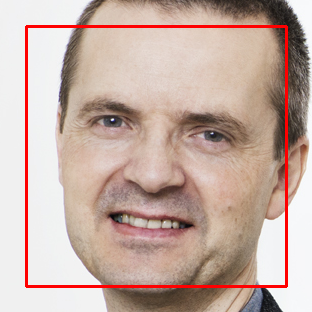

In [13]:
# Crop on PIL

# Convert cv_image to pil_image
face = Image.fromarray(cv_img)

# Convert cv box to PIL box [left, upper, right, lower]
# Calculate scale factors, boxScale values > 1 add some margin outside the box
boxScale=1.1
xDelta=max(faces[2]*(boxScale-1),0)
yDelta=max(faces[3]*(boxScale-1),0)

PIL_box=[faces[0]-xDelta, faces[1]-yDelta, faces[0]+faces[2]+xDelta, faces[1]+faces[3]+yDelta]

cropped = face.crop(tuple(PIL_box))
cropped

(128, 128)


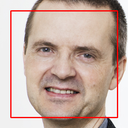

In [76]:
# Make a thumbnail
tn = cropped.copy()
tn.thumbnail((128, 128), Image.ANTIALIAS)
print(tn.size)
tn

#### Crop and resize OpenCV images

use np.slicing (left-to-right as x direction and top-to-bottom as y direction, x,y is top-left)

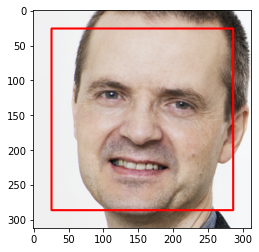

In [20]:
x,y,w,h = faces

scale_factor = 1.1
x_delta = int(max((scale_factor-1) * w, 0))
y_delta = int(max((scale_factor-1) * h, 0))

cropped = cv_img[y-y_delta:y+y_delta+h, x-x_delta:x+x_delta+w].copy()
plt.imshow(cropped)

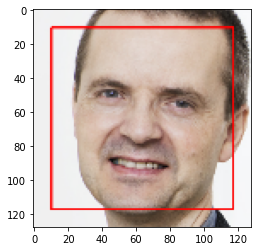

In [23]:
tn = cv2.resize(cropped, dsize=(128, 128))
assert Image.fromarray(tn).size == (128, 128)
plt.imshow(tn)

TypeError: Image data of dtype object cannot be converted to float

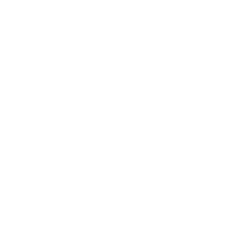

In [18]:
# Crop faces and plot
for n, face_rect in enumerate(faces):
    face = Image.fromarray(cv_img).crop(face_rect)
    plt.subplot(1, len(faces), n+1)
    plt.axis('off')
    plt.imshow(face)

In [ ]:
import cv #Opencv
import Image #Image from PIL
import glob
import os

def DetectFace(image, faceCascade, returnImage=False):
    # This function takes a grey scale cv image and finds
    # the patterns defined in the haarcascade function
    # modified from: http://www.lucaamore.com/?p=638

    #variables    
    min_size = (20,20)
    haar_scale = 1.1
    min_neighbors = 3
    haar_flags = 0

    # Equalize the histogram
    cv.EqualizeHist(image, image)

    # Detect the faces
    faces = cv.HaarDetectObjects(
            image, faceCascade, cv.CreateMemStorage(0),
            haar_scale, min_neighbors, haar_flags, min_size
        )

    # If faces are found
    if faces and returnImage:
        for ((x, y, w, h), n) in faces:
            # Convert bounding box to two CvPoints
            pt1 = (int(x), int(y))
            pt2 = (int(x + w), int(y + h))
            cv.Rectangle(image, pt1, pt2, cv.RGB(255, 0, 0), 5, 8, 0)

    if returnImage:
        return image
    else:
        return faces

def pil2cvGrey(pil_im):
    # Convert a PIL image to a greyscale cv image
    # from: http://pythonpath.wordpress.com/2012/05/08/pil-to-opencv-image/
    pil_im = pil_im.convert('L')
    cv_im = cv.CreateImageHeader(pil_im.size, cv.IPL_DEPTH_8U, 1)
    cv.SetData(cv_im, pil_im.tostring(), pil_im.size[0]  )
    return cv_im

def cv2pil(cv_im):
    # Convert the cv image to a PIL image
    return Image.fromstring("L", cv.GetSize(cv_im), cv_im.tostring())

def imgCrop(image, cropBox, boxScale=1):
    # Crop a PIL image with the provided box [x(left), y(upper), w(width), h(height)]

    # Calculate scale factors
    xDelta=max(cropBox[2]*(boxScale-1),0)
    yDelta=max(cropBox[3]*(boxScale-1),0)

    # Convert cv box to PIL box [left, upper, right, lower]
    PIL_box=[cropBox[0]-xDelta, cropBox[1]-yDelta, cropBox[0]+cropBox[2]+xDelta, cropBox[1]+cropBox[3]+yDelta]

    return image.crop(PIL_box)

def faceCrop(imagePattern,boxScale=1):
    # Select one of the haarcascade files:
    #   haarcascade_frontalface_alt.xml  <-- Best one?
    #   haarcascade_frontalface_alt2.xml
    #   haarcascade_frontalface_alt_tree.xml
    #   haarcascade_frontalface_default.xml
    #   haarcascade_profileface.xml
    faceCascade = cv.Load('haarcascade_frontalface_alt.xml')

    imgList=glob.glob(imagePattern)
    if len(imgList)<=0:
        print 'No Images Found'
        return

    for img in imgList:
        pil_im=Image.open(img)
        cv_im=pil2cvGrey(pil_im)
        faces=DetectFace(cv_im,faceCascade)
        if faces:
            n=1
            for face in faces:
                croppedImage=imgCrop(pil_im, face[0],boxScale=boxScale)
                fname,ext=os.path.splitext(img)
                croppedImage.save(fname+'_crop'+str(n)+ext)
                n+=1
        else:
            print 'No faces found:', img

def test(imageFilePath):
    pil_im=Image.open(imageFilePath)
    cv_im=pil2cvGrey(pil_im)
    # Select one of the haarcascade files:
    #   haarcascade_frontalface_alt.xml  <-- Best one?
    #   haarcascade_frontalface_alt2.xml
    #   haarcascade_frontalface_alt_tree.xml
    #   haarcascade_frontalface_default.xml
    #   haarcascade_profileface.xml
    faceCascade = cv.Load('haarcascade_frontalface_alt.xml')
    face_im=DetectFace(cv_im, faceCascade, returnImage=True)
    img=cv2pil(face_im)
    img.show()
    img.save('test.png')


# Test the algorithm on an image
#test('testPics/faces.jpg')

# Crop all jpegs in a folder. Note: the code uses glob which follows unix shell rules.
# Use the boxScale to scale the cropping area. 1=opencv box, 2=2x the width and height
faceCrop('testPics/*.jpg',boxScale=1)

In [ ]:
import dlib
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt


def detect_faces(image):

    # Create a face detector
    face_detector = dlib.get_frontal_face_detector()

    # Run detector and get bounding boxes of the faces on image.
    detected_faces = face_detector(image, 1)
    face_frames = [(x.left(), x.top(),
                    x.right(), x.bottom()) for x in detected_faces]

    return face_frames

# Load image
img_path = 'test.jpg'
image = io.imread(img_path)

# Detect faces
detected_faces = detect_faces(image)

# Crop faces and plot
for n, face_rect in enumerate(detected_faces):
    face = Image.fromarray(image).crop(face_rect)
    plt.subplot(1, len(detected_faces), n+1)
    plt.axis('off')
    plt.imshow(face)

---